In [167]:
import pyrootutils
import os

# Set the project root using the current working directory
project_root = pyrootutils.setup_root(os.getcwd(), indicator=".git", pythonpath=True, cwd=True)
print("Working directory set to:", os.getcwd())

Working directory set to: /home/ec2-user/embedding-adapter


In [168]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [169]:
import torch
import pandas as pd

from embedding_adapter.triplet_module import TripletModule
from embedding_adapter.embedding_model import EmbeddingModel
from embedding_adapter.datamodule import TripletDataModule

In [288]:
from embedding_adapter.triplet_module import TripletModule
import torch

# Load the sentence adapter from the checkpoint
checkpoint_path = f"logs/products/triplet_model_2025-04-24_01-04-55_e27e66/checkpoints/triplet-model-best-ood-val.ckpt"
adapter_model = TripletModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'))
adapter_model.eval()
dtype = adapter_model.dtype
adapter = adapter_model.adapter

In [171]:
train_tasks = pd.read_parquet("data/products/train_tasks.parquet")

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [173]:
embedding_model = EmbeddingModel(device_map="cuda") if 'embedding_model' not in locals() else locals()['embedding_model']

In [174]:
def cosine_similarity_matrix(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
    norm_tensor1 = tensor1 / tensor1.norm(dim=1, keepdim=True)
    norm_tensor2 = tensor2 / tensor2.norm(dim=1, keepdim=True)
    return torch.mm(norm_tensor1, norm_tensor2.t())

In [175]:
all_task_embeddings = torch.tensor(np.stack(train_tasks["embedding_task"]), dtype=torch.float32)

In [176]:
train_tasks

,index,task,id_task,embedding_task
21227,31806,The holiday theme represented in this gift wra...,c3bbf0aa-9380-498e-acac-ad7433e2d055,"[-0.008446, -0.001286, -0.01017, 0.0002376, -0..."
21237,31821,"Using the product details, determine the color...",5adecb64-d8af-449c-bddb-f98b443548fc,"[0.00931, -0.01588, -0.003092, -0.00923, 0.000..."
9147,10765,Analyze the opacity level of yoga pants fabric...,72f3b049-99e5-4907-b92c-dda5c94a0fac,"[0.003561, -0.000432, 0.00268, -0.002241, -0.0..."
7488,8546,The fundamental color group of this curtain pa...,4258c0ee-70f9-4922-bd12-8eb82eb2fd87,"[-0.01828, 0.02017, -0.001532, 0.005104, -0.01..."
1122,1158,What is the dominant decorative pattern featur...,093e5780-4ad6-40fd-8734-39660a10169f,"[0.007416, -0.002773, -0.003637, 0.007626, -0...."
...,...,...,...,...
7993,9226,What specific age group is targeted by this mu...,b4116115-d75d-40c3-bfac-05d25c2223ec,"[0.001499, -0.0015, 0.009796, -0.006084, 0.011..."
24022,38783,The charging interface specification needs to ...,a2d66261-5cac-4f61-aef3-161a613bc266,"[-0.00918, -0.00518, -0.003677, 0.00874, -0.00..."
23177,36606,Determine the quantity of wine bottles that ca...,cb7d0e60-9bab-4817-9d0f-1c89dfd4d8a1,"[0.01356, 0.00863, 0.003168, -0.01704, -0.0012..."
10900,13228,Find and isolate the main material used in man...,9ece22ca-ae8d-4e4a-83c5-ceaee43f4005,"[0.006294, -0.01527, -0.000468, -0.01367, -3.4..."


# Random Tasks

In [177]:
task_embeddings = torch.Tensor(np.stack(train_tasks['embedding_task'].iloc[:50].to_numpy())).to(device="cuda", dtype=dtype)

In [178]:
text_embeddings = embedding_model.encode(["x" for _ in range(50)]).to(device="cuda", dtype=dtype)

Processing batches: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


In [179]:
with torch.inference_mode():
    gates, _, _ = adapter.forward_gate(task_embeddings)
    adapted_embeddings = adapter.forward_adapter(text_embeddings, gates)

tensor([[ 6.8766e-01, -2.3136e-01, -5.5759e-01,  7.2204e-01, -3.8178e-01,
         -1.7208e-01, -3.1183e-01, -6.5757e-01, -8.1606e-01,  6.2348e-01,
         -4.1693e-01,  7.9880e-01, -1.3348e+00, -2.7504e-01, -1.2684e+00,
         -2.6013e-01],
        [ 6.7097e-01, -2.6566e-01, -3.0389e-01,  7.3692e-01, -3.9238e-01,
         -2.3361e-01, -3.4813e-01, -5.4223e-01, -9.3599e-01,  6.2274e-01,
         -6.7309e-01,  8.1542e-01, -1.0036e+00, -2.8317e-01, -8.5411e-01,
         -3.6382e-01],
        [-2.7061e-01,  2.7498e+00, -5.9672e-01, -2.6555e-01,  8.9772e-02,
         -1.6499e-01,  2.5983e+00, -5.5535e-01,  2.6430e+00, -3.8492e-01,
          9.6267e-01, -5.6207e-01, -9.5978e-01, -4.5423e-01, -8.3260e-01,
          4.5602e-02],
        [ 5.1667e-01, -3.4433e-01, -3.0985e-01,  7.4173e-01, -4.0478e-01,
         -2.7783e-01, -3.9263e-01, -4.9275e-01, -8.0539e-01,  1.2201e+00,
         -7.2262e-01,  3.2852e-01, -7.8945e-01, -2.4401e-01, -4.3649e-01,
         -3.9299e-01],
        [ 6.9965e-01

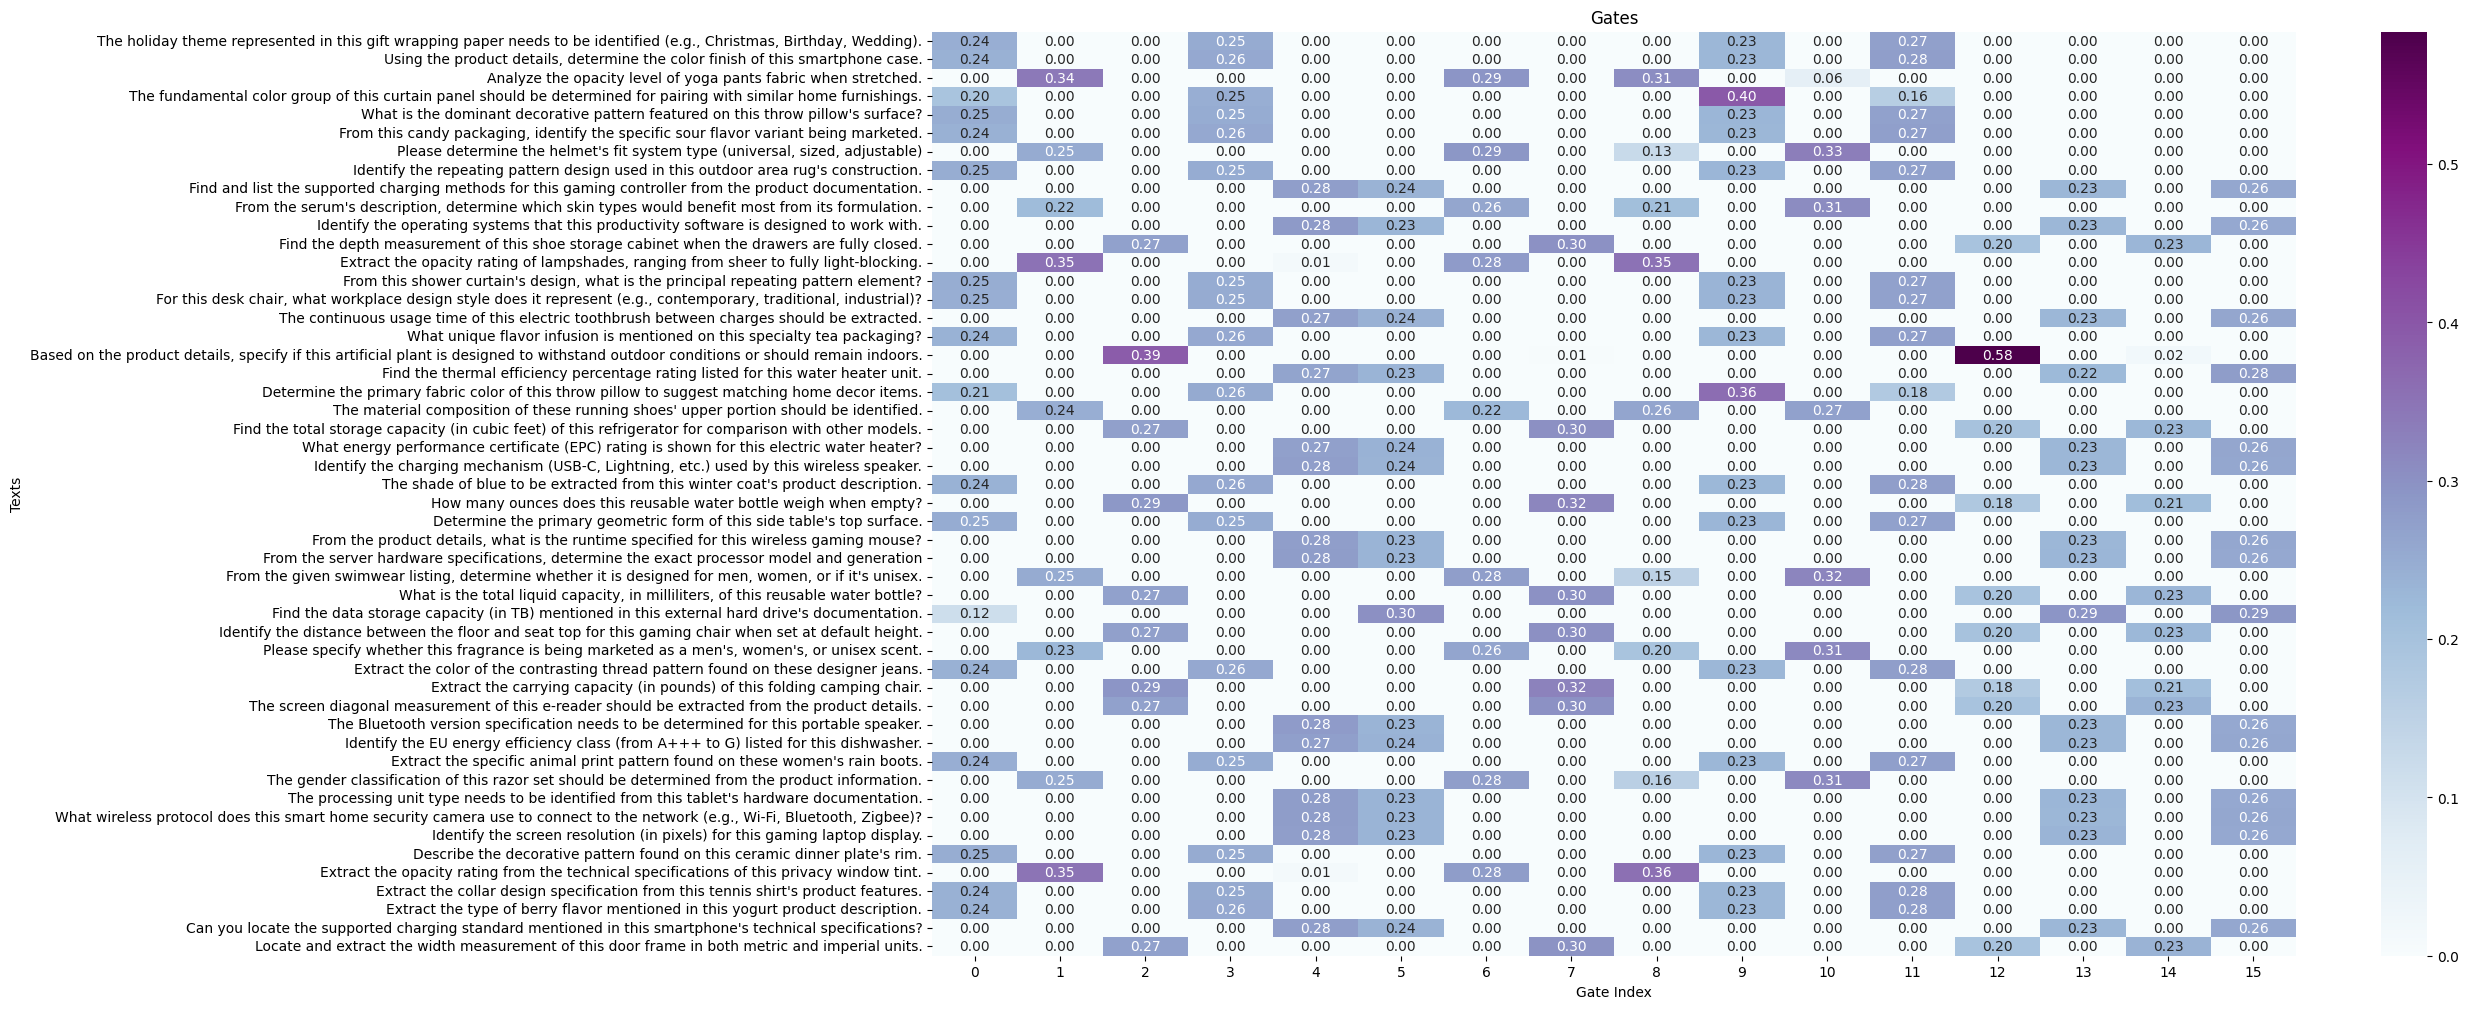

In [180]:
plt.figure(figsize=(22, 12))
sns.heatmap(gates.cpu().numpy(), annot=True, fmt=".2f", cmap="BuPu")
plt.title("Gates")
plt.xlabel("Gate Index")
plt.ylabel("Texts")
plt.yticks(np.arange(50) + 0.5, train_tasks['task'].iloc[:50].to_list(), rotation=0)
plt.show()

# Example 1

In [181]:
task = "Identify the total connectivity options."
task_embedding = embedding_model.encode([task]).to(device="cuda", dtype=dtype)
print(task)

Processing batches: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]

Identify the total connectivity options.


In [182]:
texts = [
  # Wi-Fi
  "Smart LED Light Strip: Transform your ambiance with our Wi-Fi enabled light strip. Control colors, brightness, and set schedules directly from your smartphone, creating the perfect atmosphere for any occasion.",
  # Wi-Fi
  "Smart Air Purifier: Breathe easier with our Wi-Fi connected air purifier. Monitor air quality, adjust settings, and receive alerts from anywhere, ensuring a healthy home environment.",
  # Wi-Fi
  "Smart Irrigation System: Keep your garden thriving with our Wi-Fi irrigation system. Set watering schedules, monitor soil moisture, and control your sprinklers remotely for optimal plant health.",
  # Zigbee
  "Smart Motion Sensor: Enhance your home security with our Zigbee motion sensor. Receive instant alerts on your smartphone when motion is detected, and automate lighting or security systems for added safety.",
  # Zigbee
  "Smart Blind Controller: Automate your window blinds with our Zigbee controller. Set schedules, adjust tilt, and integrate with other smart home devices for optimal light control and privacy.",
  # Zigbee
  "Smart Appliance Energy Monitor: Track and optimize energy usage of your appliances with our Zigbee energy monitor. Get real-time data and insights to reduce your electricity bills.",
  # Bluetooth
  "Smart Plant Sensor: Monitor the health of your indoor plants with our Bluetooth plant sensor. Get real-time data on soil moisture, light levels, and temperature directly on your smartphone.",
  # Bluetooth
  "Smart Personal Fan: Stay cool and comfortable with our personal fan. Control fan speed, oscillation, and timer settings directly from your smartphone via Bluetooth.",
  # Bluetooth
  "Smart Mattress Pad: Improve your sleep quality with our Bluetooth mattress pad. Adjust temperature, set schedules, and track your sleep patterns for a more restful night."
]

In [183]:
text_embeddings = embedding_model.encode(texts).to(device="cuda", dtype=dtype)

Processing batches: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


In [184]:
text_embeddings.dtype

torch.float32

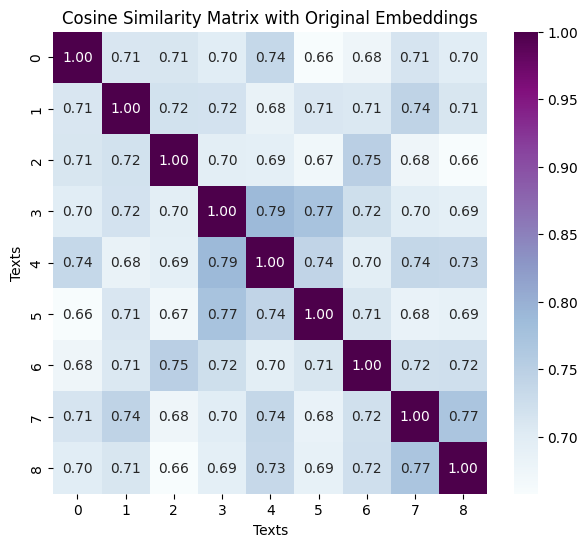

In [185]:
similarity_matrix = cosine_similarity_matrix(text_embeddings, text_embeddings).cpu().numpy()

plt.figure(figsize=(7, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="BuPu")
plt.title("Cosine Similarity Matrix with Original Embeddings")
plt.xlabel("Texts")
plt.ylabel("Texts")
plt.show()

In [186]:
with torch.inference_mode():
    gates, _, _ = adapter.forward_gate(task_embedding.repeat(text_embeddings.size(0), 1))
    adapted_embeddings = adapter.forward_adapter(text_embeddings, gates)

tensor([[ 0.3075, -0.4639, -1.0112, -0.2321,  0.9790,  0.7801, -0.2808, -1.1384,
         -2.6562,  0.3935, -0.2583,  0.3071, -1.3875,  0.7695, -1.6680,  0.8820],
        [ 0.3075, -0.4639, -1.0112, -0.2321,  0.9790,  0.7801, -0.2808, -1.1384,
         -2.6562,  0.3935, -0.2583,  0.3071, -1.3875,  0.7695, -1.6680,  0.8820],
        [ 0.3075, -0.4639, -1.0112, -0.2321,  0.9790,  0.7801, -0.2808, -1.1384,
         -2.6562,  0.3935, -0.2583,  0.3071, -1.3875,  0.7695, -1.6680,  0.8820],
        [ 0.3075, -0.4639, -1.0112, -0.2321,  0.9790,  0.7801, -0.2808, -1.1384,
         -2.6562,  0.3935, -0.2583,  0.3071, -1.3875,  0.7695, -1.6680,  0.8820],
        [ 0.3075, -0.4639, -1.0112, -0.2321,  0.9790,  0.7801, -0.2808, -1.1384,
         -2.6562,  0.3935, -0.2583,  0.3071, -1.3875,  0.7695, -1.6680,  0.8820],
        [ 0.3075, -0.4639, -1.0112, -0.2321,  0.9790,  0.7801, -0.2808, -1.1384,
         -2.6562,  0.3935, -0.2583,  0.3071, -1.3875,  0.7695, -1.6680,  0.8820],
        [ 0.3075, -0.4

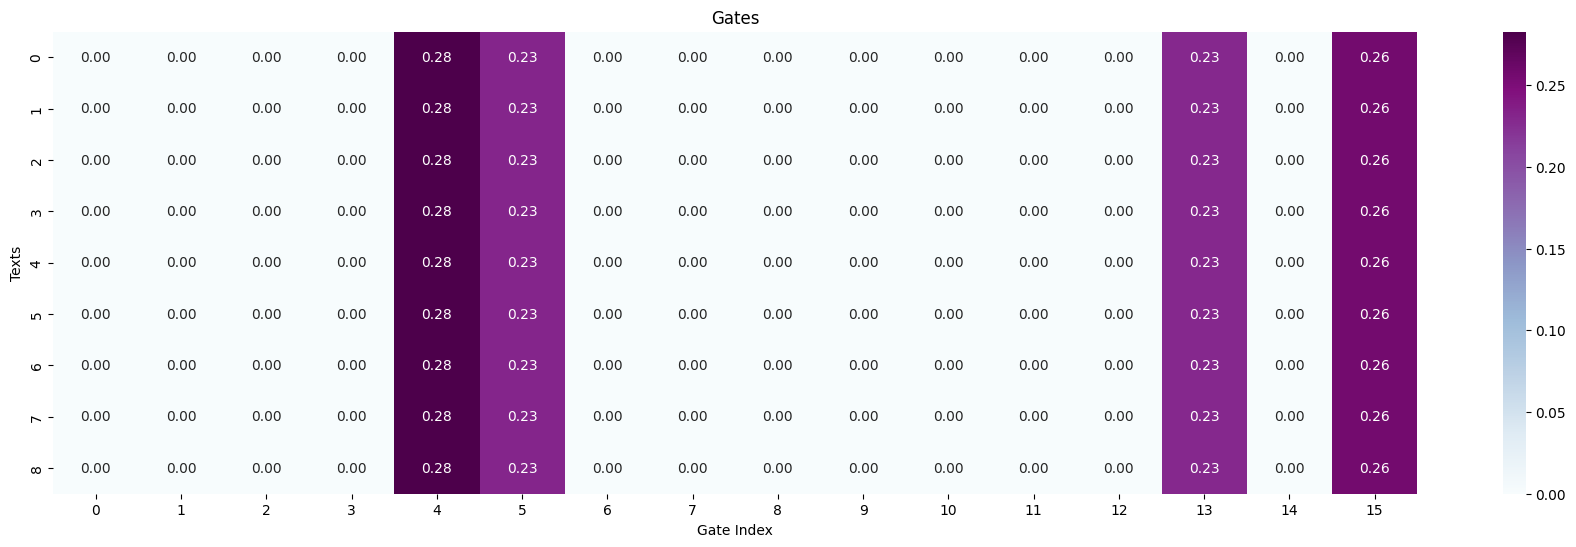

In [187]:
plt.figure(figsize=(22, 6))
sns.heatmap(gates.cpu().numpy(), annot=True, fmt=".2f", cmap="BuPu")
plt.title("Gates")
plt.xlabel("Gate Index")
plt.ylabel("Texts")
plt.show()

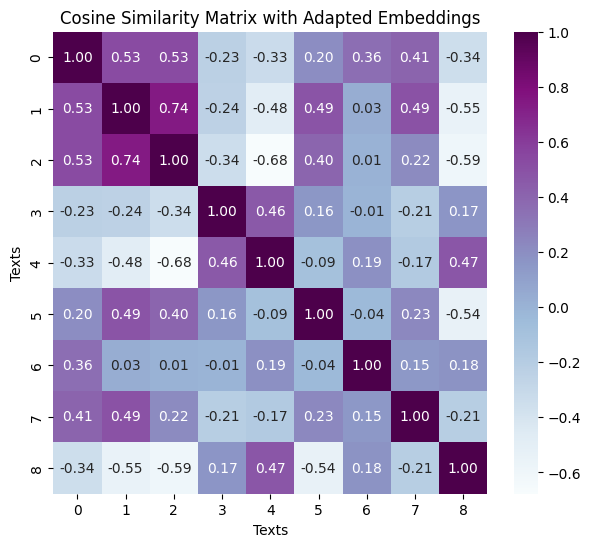

In [188]:
similarity_matrix = cosine_similarity_matrix(adapted_embeddings, adapted_embeddings).cpu().numpy()

plt.figure(figsize=(7, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="BuPu")
plt.title("Cosine Similarity Matrix with Adapted Embeddings")
plt.xlabel("Texts")
plt.ylabel("Texts")
plt.show()

# Example 2

In [189]:
task = "Identify the total storage capacity."
task_embedding = embedding_model.encode([task]).to(device="cuda", dtype=dtype)
print(task)

Processing batches: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]

Identify the total storage capacity.


In [190]:
texts = [
  # 250GB Storage
  "Experience fast boot times and application loading with this reliable 250GB SSD, perfect for everyday computing.",
  # 250GB Storage
  "Upgrade your system with this portable 250GB SSD, offering reliable storage for your data.",
  # 250GB Storage
  "Unleash high-speed performance with this 250GB NVMe SSD, designed for demanding applications and gaming.",
  # 500GB Storage
  "Experience fast boot times and application loading with this reliable 500GB SSD, perfect for everyday computing.",
  # 500GB Storage
  "Upgrade your system with this portable 500GB SSD, offering reliable storage for your data.",
  # 500GB Storage
  "Unleash high-speed performance with this 500GB NVMe SSD, designed for demanding applications and gaming.",
  # 1TB Storage
  "Store your media library and documents with this spacious 1TB internal hard drive, offering reliable storage for your data.",
  # 1TB Storage
  "Enjoy fast transfer speeds and ample storage with this 1TB external SSD, perfect for content creators and gamers.",
  # 1TB Storage
  "1TB Hybrid Drive: Get the best of both worlds with this 1TB hybrid drive, combining the speed of SSD with the capacity of HDD.",
  # 2TB Storage
  "Upgrade your system with this high-performance 2TB SSD, providing ample space for your operating system, applications, and games.",
  # 2TB Storage
  "2TB External HDD: Expand your storage capacity with this 2TB external hard drive, ideal for backing up large files and storing media collections.",
  # 2TB Storage
  "Build your own network-attached storage with this 2TB NAS-rated hard drive, designed for 24/7 operation and reliable data storage."
]

In [191]:
text_embeddings = embedding_model.encode(texts).to(device="cuda", dtype=dtype)

Processing batches: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


In [192]:
text_embeddings.dtype

torch.float32

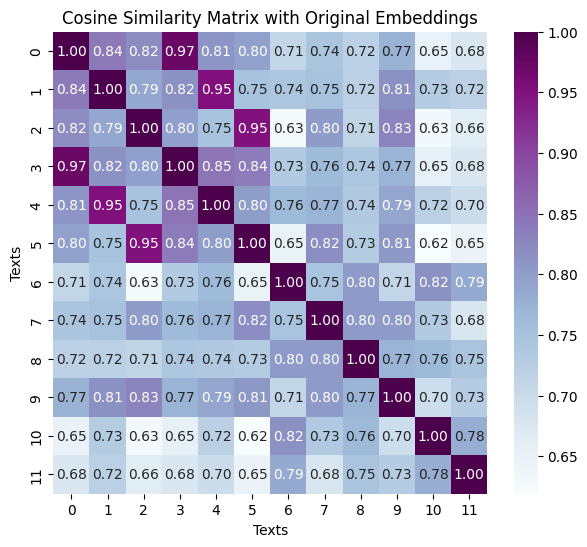

In [193]:
similarity_matrix = cosine_similarity_matrix(text_embeddings, text_embeddings).cpu().numpy()

plt.figure(figsize=(7, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="BuPu")
plt.title("Cosine Similarity Matrix with Original Embeddings")
plt.xlabel("Texts")
plt.ylabel("Texts")
plt.show()

In [194]:
with torch.inference_mode():
    gates, _, _ = adapter.forward_gate(task_embedding.repeat(text_embeddings.size(0), 1))
    adapted_embeddings = adapter.forward_adapter(text_embeddings, gates)

tensor([[ 0.1840, -0.0918,  0.4554, -0.9695, -0.3962,  0.8495, -0.0169,  0.5937,
         -0.7734, -0.0231,  0.0484, -0.0552,  0.2602,  0.8495, -0.1646,  0.8366],
        [ 0.1840, -0.0918,  0.4554, -0.9695, -0.3962,  0.8495, -0.0169,  0.5937,
         -0.7734, -0.0231,  0.0484, -0.0552,  0.2602,  0.8495, -0.1646,  0.8366],
        [ 0.1840, -0.0918,  0.4554, -0.9695, -0.3962,  0.8495, -0.0169,  0.5937,
         -0.7734, -0.0231,  0.0484, -0.0552,  0.2602,  0.8495, -0.1646,  0.8366],
        [ 0.1840, -0.0918,  0.4554, -0.9695, -0.3962,  0.8495, -0.0169,  0.5937,
         -0.7734, -0.0231,  0.0484, -0.0552,  0.2602,  0.8495, -0.1646,  0.8366],
        [ 0.1840, -0.0918,  0.4554, -0.9695, -0.3962,  0.8495, -0.0169,  0.5937,
         -0.7734, -0.0231,  0.0484, -0.0552,  0.2602,  0.8495, -0.1646,  0.8366],
        [ 0.1840, -0.0918,  0.4554, -0.9695, -0.3962,  0.8495, -0.0169,  0.5937,
         -0.7734, -0.0231,  0.0484, -0.0552,  0.2602,  0.8495, -0.1646,  0.8366],
        [ 0.1840, -0.0

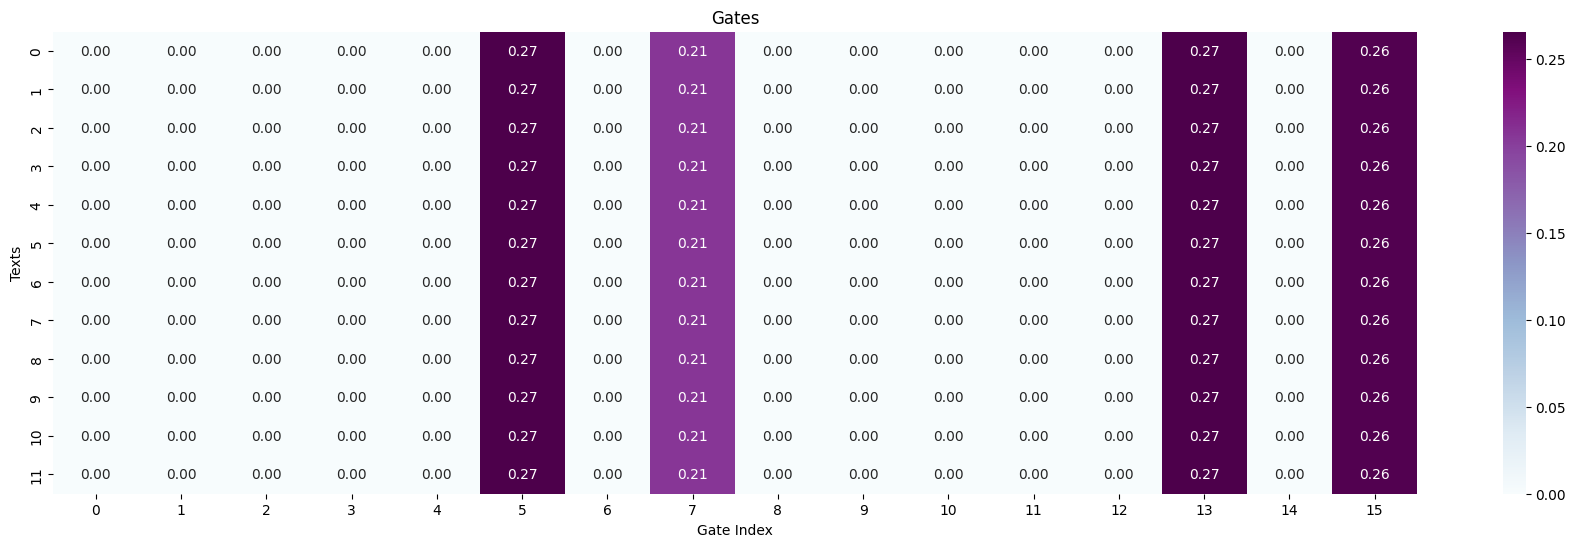

In [195]:
plt.figure(figsize=(22, 6))
sns.heatmap(gates.cpu().numpy(), annot=True, fmt=".2f", cmap="BuPu")
plt.title("Gates")
plt.xlabel("Gate Index")
plt.ylabel("Texts")
plt.show()


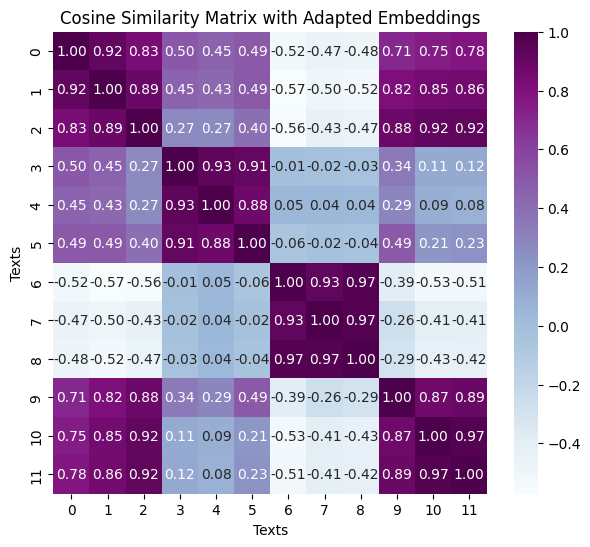

In [196]:
similarity_matrix = cosine_similarity_matrix(adapted_embeddings, adapted_embeddings).cpu().numpy()

plt.figure(figsize=(7, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="BuPu")
plt.title("Cosine Similarity Matrix with Adapted Embeddings")
plt.xlabel("Texts")
plt.ylabel("Texts")
plt.show()

## Example 3

In [197]:
task = "Identify the color of the product."
task_embedding = embedding_model.encode([task]).to(device="cuda", dtype=dtype)
print(task)

Processing batches: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]

Identify the color of the product.


In [304]:
df = pd.read_csv("raw_data/amazon/amazon_color.csv")
texts = df["text"].to_list()
labels = df["color"].to_list()

In [305]:
text_embeddings = embedding_model.encode(texts, max_length=512, batch_size=32).to(device="cuda", dtype=dtype)

Processing batches: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


In [306]:
with torch.inference_mode():
    gates, _, _ = adapter.forward_gate(task_embedding.repeat(text_embeddings.size(0), 1))
    adapted_embeddings = adapter.forward_adapter(text_embeddings, gates)

tensor([[ 0.8436, -0.9335, -0.9051,  ..., -0.5202, -0.8904, -0.4764],
        [ 0.8436, -0.9335, -0.9051,  ..., -0.5202, -0.8904, -0.4764],
        [ 0.8436, -0.9335, -0.9051,  ..., -0.5202, -0.8904, -0.4764],
        ...,
        [ 0.8436, -0.9335, -0.9051,  ..., -0.5202, -0.8904, -0.4764],
        [ 0.8436, -0.9335, -0.9051,  ..., -0.5202, -0.8904, -0.4764],
        [ 0.8436, -0.9335, -0.9051,  ..., -0.5202, -0.8904, -0.4764]],
       device='cuda:0')


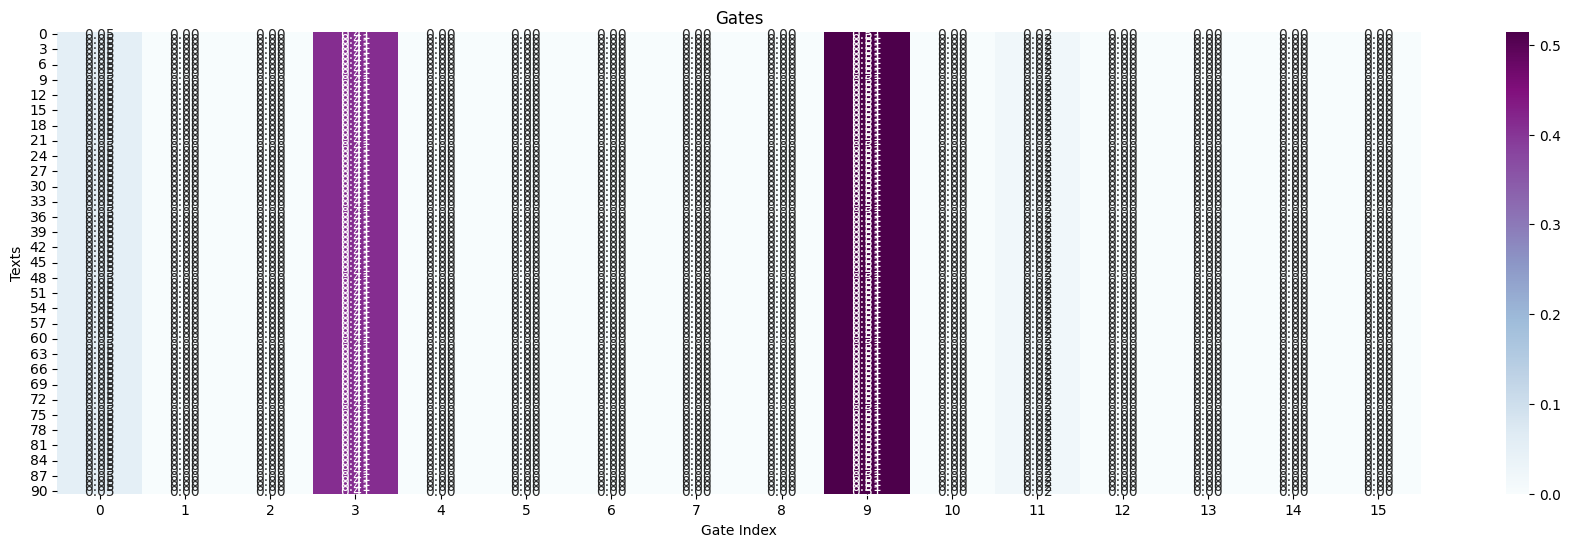

In [307]:
plt.figure(figsize=(22, 6))
sns.heatmap(gates.cpu().numpy(), annot=True, fmt=".2f", cmap="BuPu")
plt.title("Gates")
plt.xlabel("Gate Index")
plt.ylabel("Texts")
plt.show()

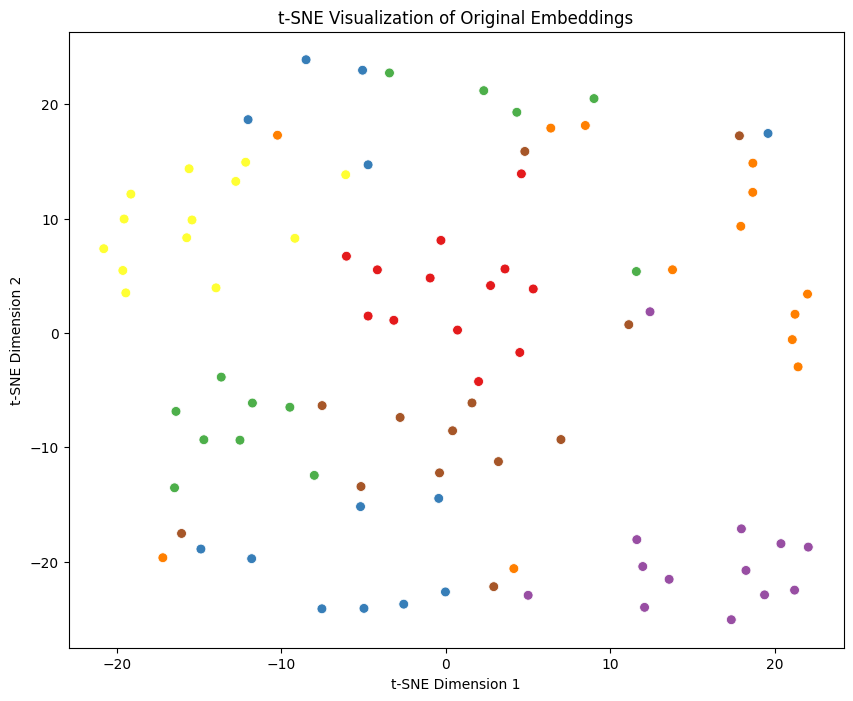

In [308]:
from sklearn.manifold import TSNE

# Reduce the dimensionality of adapted_embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
text_embeddings_2d = tsne.fit_transform(text_embeddings.cpu().numpy())

# Plot the t-SNE result with data index
plt.figure(figsize=(10, 8))
sns.scatterplot(x=text_embeddings_2d[:, 0], y=text_embeddings_2d[:, 1], s=50, hue=labels, palette="Set1", legend=False)
plt.title("t-SNE Visualization of Original Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

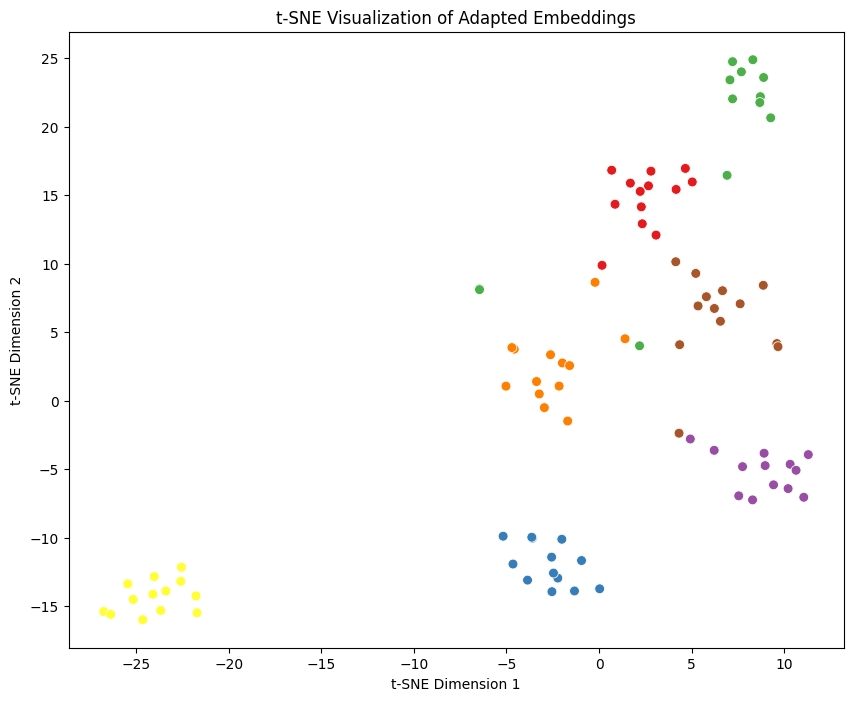

: 

In [ ]:
from sklearn.manifold import TSNE

# Reduce the dimensionality of adapted_embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
adapted_embeddings_2d = tsne.fit_transform(adapted_embeddings.cpu().numpy())

# Plot the t-SNE result with data index
plt.figure(figsize=(10, 8))
sns.scatterplot(x=adapted_embeddings_2d[:, 0], y=adapted_embeddings_2d[:, 1], s=50, hue=labels, palette="Set1", legend=False)
plt.title("t-SNE Visualization of Adapted Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

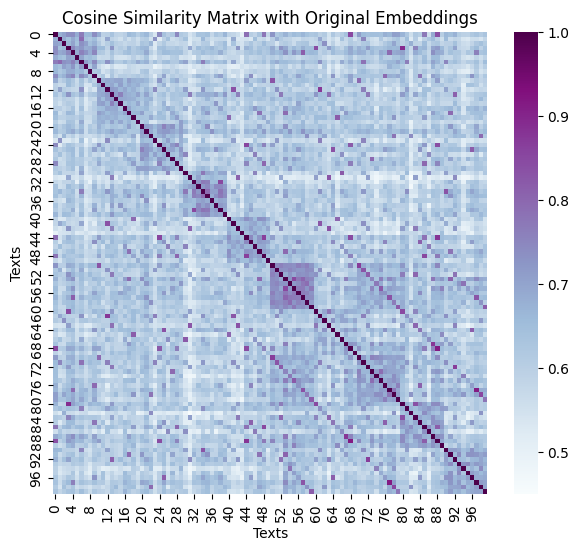

In [295]:
similarity_matrix = cosine_similarity_matrix(text_embeddings, text_embeddings).cpu().numpy()

plt.figure(figsize=(7, 6))
sns.heatmap(similarity_matrix, cmap="BuPu")
plt.title("Cosine Similarity Matrix with Original Embeddings")
plt.xlabel("Texts")
plt.ylabel("Texts")
plt.show()

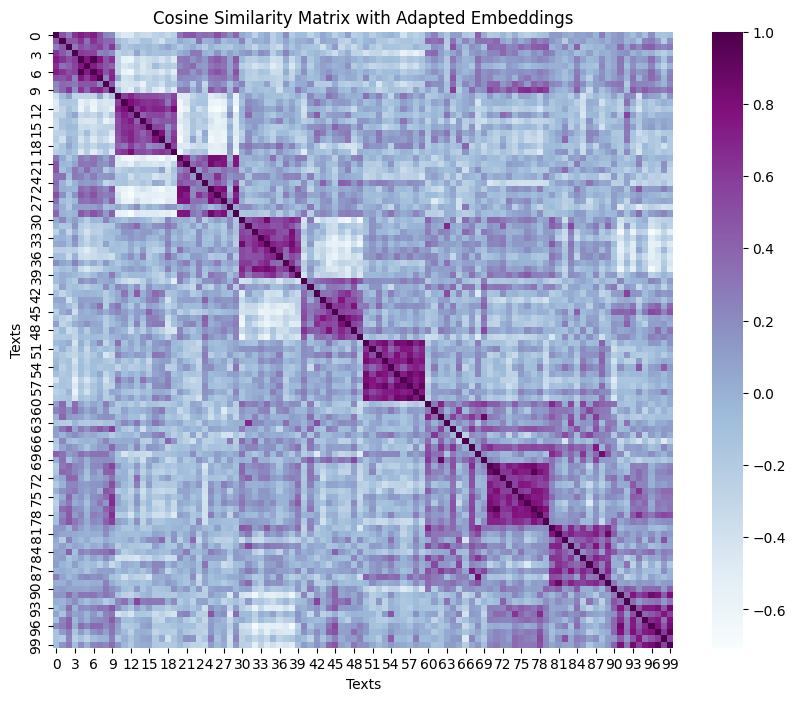

In [296]:
similarity_matrix = cosine_similarity_matrix(adapted_embeddings, adapted_embeddings).cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="BuPu")
plt.title("Cosine Similarity Matrix with Adapted Embeddings")
plt.xlabel("Texts")
plt.ylabel("Texts")
plt.show()